In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
import regex
from sklearn.metrics import accuracy_score

import tweepy

# Part I: Training the model with Dataset

In [2]:
DATASET_ENCODING = "ISO-8859-1"
header_list = ["sentiment", "id", "time", "query", "user", "text"]
tweets_df = pd.read_csv("tweets_data.csv", encoding=DATASET_ENCODING, names=header_list)
tweets_df = tweets_df.drop(columns=["id", "time", "query", "user"])

In [3]:
tweets_df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


### Clean the text

In [4]:
%%time

# Create a function to clean the tweets
def cleanTxt(text):
    text = regex.sub('@[A-Za-z0-9]+', '',text) # Remove @mentions
    text = regex.sub('#','',text) # Remove the '#' symbol
    text = regex.sub('RT[\s]','',text) # Remove RT
    text = regex.sub('https?://\S+', '', text) # Remove hyper link
    text = regex.sub('[":;“”)(]?', '', text) # Remove the other special characters
    text = regex.sub('&amp', 'and', text) 
    return text

# Cleaning the Text
tweets_df['text'] = tweets_df['text'].apply(cleanTxt)

# Show the Cleaned Data
tweets_df

Wall time: 1min 39s


,sentiment,text
0,0,"- Awww, that's a bummer. You shoulda got Da..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [5]:
tweets_df.shape[0]

1600000

In [6]:
# Make range (0-1)
def rangeone(sent):
    if sent == 4:
        sent = 1
    return sent
tweets_df['sentiment'] = tweets_df['sentiment'].apply(rangeone)

In [8]:
tweets_df

,sentiment,text
0,0,"- Awww, that's a bummer. You shoulda got Da..."
1,0,is upset that he can't update his Facebook by ...
2,0,I dived many times for the ball. Managed to s...
3,0,my whole body feels itchy and like its on fire
4,0,"no, it's not behaving at all. i'm mad. why am..."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


## Vectorizing our data using Universal Sentence Encoder

In [9]:
%%time
modeltf = keras.models.load_model('universal-sentence-encoder_4')

Wall time: 35.3 s


In [9]:
# checking model
embeddings = modeltf([
    'The quick brown fox jumps over the lazy dog.',
    "I am a sentence for which I would like to get its embedding"])
embeddings

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[-0.03133016, -0.06338634, -0.01607501, ..., -0.03242781,
        -0.04575741,  0.05370455],
       [ 0.05080863, -0.01652433,  0.01573783, ...,  0.00976659,
         0.03170121,  0.01788118]], dtype=float32)>

In [12]:
targets = tweets_df.sentiment.values
targets.shape

(1600000,)

In [64]:
%%time
with tf.device('cpu:0'):
    a1 = modeltf(tweets_df['text'][:100000].tolist()).numpy()

    for i in range(1,16):
        a2 = modeltf(tweets_df['text'][i*100000:(i+1)*100000].tolist()).numpy()
        a1 = np.append(a1,a2, axis = 0)
    embedded_tweets = a1

Wall time: 2min 47s


In [67]:
embedded_tweets.shape

(1600000, 512)

In [68]:
targets.shape

(1600000,)

## Model

In [69]:
model = keras.Sequential([

    # input layer
    keras.layers.Input(shape=(512,), dtype='float32'),

    # 1st dense layer
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.25),

    # 2nd dense layer
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.25),

    # output layer
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 73,985
Trainable params: 73,985
Non-trainable params: 0
_________________________________________________________________


### Split Data

In [70]:
def prepare_datasets(X, y, test_size, validation_size):
    
    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [71]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(embedded_tweets, targets, 0.25, 0.2)

In [72]:
print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape)

(960000, 512) (240000, 512) (400000, 512) (960000,) (240000,) (400000,)


## Actual Training

In [88]:
%%time

num_epochs = 10
batch_size = 32   

history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                    epochs=num_epochs, batch_size=batch_size)

Train on 960000 samples, validate on 240000 samples
Epoch 1/10
960000/960000 [==============================] - 103s 107us/sample - loss: 0.4295 - acc: 0.8006 - val_loss: 0.4231 - val_acc: 0.8034
Epoch 2/10
960000/960000 [==============================] - 100s 104us/sample - loss: 0.4246 - acc: 0.8036 - val_loss: 0.4207 - val_acc: 0.8045
Epoch 3/10
960000/960000 [==============================] - 104s 109us/sample - loss: 0.4211 - acc: 0.8058 - val_loss: 0.4198 - val_acc: 0.8048
Epoch 4/10
960000/960000 [==============================] - 109s 114us/sample - loss: 0.4188 - acc: 0.8072 - val_loss: 0.4206 - val_acc: 0.8055
Epoch 5/10
960000/960000 [==============================] - 112s 117us/sample - loss: 0.4167 - acc: 0.8080 - val_loss: 0.4198 - val_acc: 0.8056
Epoch 6/10
960000/960000 [==============================] - 113s 118us/sample - loss: 0.4149 - acc: 0.8087 - val_loss: 0.4205 - val_acc: 0.8059
Epoch 7/10
960000/960000 [==============================] - 114s 119us/sample - loss

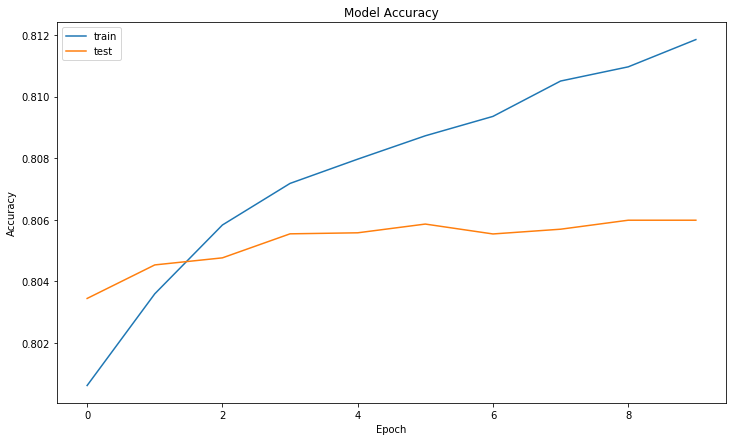

In [196]:
plt.figure(figsize=(12,7))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy') 
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Accuracy of model = 80.52%

In [90]:
predictions = np.around(model.predict(X_test))
acc = accuracy_score(predictions,y_test)*100

print('Test accuracy is {}%'.format(round(acc,2)))

Test accuracy is 80.52%


### Save Model

In [91]:
!mkdir -p saved_model
model.save('saved_model\\Sentiment_mlp')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model\Sentiment_mlp\assets


### Use Saved Model

In [97]:
model1 = keras.models.load_model('saved_model\\Sentiment_mlp')

In [102]:
model1.build((512,None))

In [104]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  65664     
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  8256      
_________________________________________________________________
dropout_1 (Dropout)          multiple                  0         
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 73,985
Trainable params: 73,985
Non-trainable params: 0
_________________________________________________________________


In [105]:
predictions = np.around(model1.predict(X_test))
acc = accuracy_score(predictions,y_test)*100

print('Test accuracy is {}%'.format(round(acc,2)))

Test accuracy is 80.52%


# Part II: Use Model for Sentiment analysis of actual Tweets

In [107]:
# APP NAME: TSenti_Analysis

In [108]:
# Get the login data
log = pd.read_csv('login.csv')

In [110]:
# Twitter API credentials
consumerKey = log['key'][0]
consumerSecret = log['key'][1]
accessToken = log['key'][2]
accessTokenSecret = log['key'][3]

In [111]:
# Create the auhentication object
authenticate = tweepy.OAuthHandler(consumerKey, consumerSecret)

# Set the access token and access token secret
authenticate.set_access_token(accessToken,accessTokenSecret)

# Create the API object while passing in the auth information
api = tweepy.API(authenticate, wait_on_rate_limit=True)

### Number of tweets to be extracted

In [174]:
no_tweets = 300

### Twitter Handle of user

In [175]:
user_handle = 'sachin_rt'

In [176]:
# Extract tweets from the twitter user
posts = api.user_timeline(screen_name=user_handle, count= no_tweets, lang= "en", tweet_mode="extended")

# Print the last 5 tweets from the account
print("Show the 5 recent tweets :\n")
i = 1
for tweet in posts[0:5]:
    print(f'{i})', tweet.full_text + '\n')
    i+=1

Show the 5 recent tweets :

1) @true_rohit_fan @ivivianrichards @unacademy Dear Pratik, all the best for your exam! 
Hope you do well and make your parents very proud. 

Now focus on studying and no more browsing social media till your exams are over..Deal? 😋

2) @VVSLaxman281 Thank you Lax! Sport is a constant teacher.

3) Happy birthday Shankar!
Keep bringing joy to listeners with your soulful voice &amp; continue to inspire the next generation to take up music! Have a good one my friend. https://t.co/oSM0EbJbu5

4) @IrfanPathan Those moments were made special by the presence of teammates like you, my friend!

5) @virendersehwag Really glad to have had you as a part of my journey Viru, see you soon. 😀



### Preparing Tweets for testing

In [177]:
# Handling ellipses at end of ReTweets

def handleRT(post):
    if hasattr(post, "retweeted_status"): # check if a retweet
        post.full_text = post.retweeted_status.full_text
    return post

for post in posts:
    post = handleRT(post)

In [178]:
# Create a dataframe with a column called Tweets
df = pd.DataFrame( [tweet.full_text for tweet in posts], columns=['Tweets'])

# Show the first 5 rows of data
df.head()

,Tweets
0,@true_rohit_fan @ivivianrichards @unacademy De...
1,@VVSLaxman281 Thank you Lax! Sport is a consta...
2,Happy birthday Shankar!\nKeep bringing joy to ...
3,@IrfanPathan Those moments were made special b...
4,@virendersehwag Really glad to have had you as...


In [179]:
# Cleaning the Text
df['Tweets'] = df['Tweets'].apply(cleanTxt)

# Show the Cleaned Data
df.head()

,Tweets
0,"_rohit_fan Dear Pratik, all the best for you..."
1,Thank you Lax! Sport is a constant teacher.
2,Happy birthday Shankar!\nKeep bringing joy to ...
3,Those moments were made special by the presen...
4,Really glad to have had you as a part of my j...


### Sentiment Analysis of Tweets

In [180]:
def getSentiment(text):
    #Vectorizing
    vec_tweet = modeltf([text]).numpy()
    # prediction
    sentiment_prediction = np.around(model1.predict(vec_tweet),2)
    
    return sentiment_prediction[0][0]

In [181]:
df['Sentiment_val'] = df['Tweets'].apply(getSentiment)

In [182]:
df.head()

,Tweets,Sentiment_val
0,"_rohit_fan Dear Pratik, all the best for you...",0.66
1,Thank you Lax! Sport is a constant teacher.,0.54
2,Happy birthday Shankar!\nKeep bringing joy to ...,1.00
3,Those moments were made special by the presen...,0.90
4,Really glad to have had you as a part of my j...,0.99


In [183]:
def getAnalysis(score):
    if score < 0.5:
        return 'Negative'
    if score == 0.5:
        return 'Neutral'
    else:
        return 'Positive'

In [184]:
df['Analysis'] = df['Sentiment_val'].apply(getAnalysis)

In [185]:
df

,Tweets,Sentiment_val,Analysis
0,"_rohit_fan Dear Pratik, all the best for you...",0.66,Positive
1,Thank you Lax! Sport is a constant teacher.,0.54,Positive
2,Happy birthday Shankar!\nKeep bringing joy to ...,1.00,Positive
3,Those moments were made special by the presen...,0.90,Positive
4,Really glad to have had you as a part of my j...,0.99,Positive
...,...,...,...
195,.’s overs are going to be the key ones for MI ...,0.26,Negative
196,_sam0708 Well done 👍🏻,0.88,Positive
197,What a catch by _manishpandey !\nTremendous at...,0.79,Positive
198,How much do you think will score at the end o...,0.90,Positive


In [186]:
# Show the value counts
print(df['Analysis'].value_counts())

Positive    166
Negative     33
Neutral       1
Name: Analysis, dtype: int64


In [187]:
# Displaying order : [Positive, Negative, Neutral]
disp = pd.Series(dtype='int64')
disp['Positive'] = df['Analysis'].value_counts()['Positive']
disp['Negative'] = df['Analysis'].value_counts()['Negative']
disp['Neutral'] = df['Analysis'].value_counts()['Neutral']

disp

Positive    166
Negative     33
Neutral       1
dtype: int64

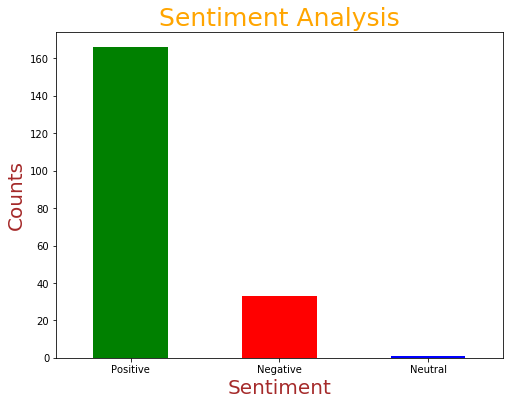

In [188]:
# Plot and visualize the counts

plt.figure(figsize=(8,6))
plt.title('Sentiment Analysis',size=25, color='orange')
plt.xlabel('Sentiment',fontdict={'size' : 20, 'color' : 'brown'})
plt.ylabel('Counts',fontdict={'size' : 20, 'color' : 'brown'})
disp.plot(kind='bar', color=['g','r','b'], rot=0)
plt.show()

In [189]:
# Print all of the Positive tweets
j=1
for i in range(0, df.shape[0]):   # (100,4) shape
    if df['Analysis'][i]=='Positive':
        print(str(j)+') '+ df['Tweets'][i]+'\n')
        j+=1

1) _rohit_fan   Dear Pratik, all the best for your exam! 
Hope you do well and make your parents very proud. 

Now focus on studying and no more browsing social media till your exams are over..Deal? 😋

2)  Thank you Lax! Sport is a constant teacher.

3) Happy birthday Shankar!
Keep bringing joy to listeners with your soulful voice and continue to inspire the next generation to take up music! Have a good one my friend. 

4)  Those moments were made special by the presence of teammates like you, my friend!

5)  Really glad to have had you as a part of my journey Viru, see you soon. 😀

6)   Your kind words mean a lot to me, Sir Viv. Take care.

7) Some special memories came flooding back.
TheGreatestLesson that I'll remember for life- one that helped me through many highs and lows on the 22 yards, while playing for India!

Chase your dreams but make sure you don't find shortcuts. The path may be difficult but never give up. 

8)  In a high pressure match you were so calm and composed. I c

In [190]:
# Print all of the Negative tweets
j=1
for i in range(0, df.shape[0]):   # (100,4) shape
    if df['Analysis'][i]=='Negative':
        print(str(j)+') '+ df['Tweets'][i]+'\n')
        j+=1

1) India’s sovereignty cannot be compromised. External forces can be spectators but not participants. 
Indians know India and should decide for India. Let's remain united as a nation.
IndiaTogether 
IndiaAgainstPropaganda

2) EVERY SESSION WE DISCOVERED A NEW HERO.
Every time we got hit, we stayed put and stood taller. We pushed boundaries of belief to play fearless but not careless cricket. Injuries and uncertainties were countered with poise and confidence. One of the greatest series wins!
Congrats India. 

3) It was Mohd. Siraj's ability and not the pitch that brought the ball in yesterday on Day 1 of the 4th Test!

AUSvIND 

4) Really sorry to hear about the demise of your father  and . 
Condolences to your family and friends. 
May God give you strength in these difficult times.

5) You're on the 𝗪𝗥𝗢𝗡𝗚 𝗦𝗜𝗗𝗘 of everyone when you drive on the 𝗪𝗥𝗢𝗡𝗚 𝗦𝗜𝗗𝗘 of the road! 

9,200 people in 🇮🇳 died in 2019 due to wrong side driving which is more than 1 death an hour.

I even saw someone dri

In [191]:
# Print all of the Neutral tweets
j=1
for i in range(0, df.shape[0]):   # (100,4) shape
    if df['Analysis'][i]=='Neutral':
        print(str(j)+') '+ df['Tweets'][i]+'\n')
        j+=1

1) A 1000 children have had free heart surgeries at  since the pandemic began.

I am delighted to be a part of this ‘Gift of Life Ceremony’ with these children and 🏥 staff.

Join me in celebrating this ❤️ warming event with them at 6️⃣ pm today➡️ 



# End